# Covid Planes Project Research

This document mainly focuses on network research portion of the project.


### Data Sources
Dataset:
https://www.bts.gov/browse-statistical-products-and-data/bts-publications/data-bank-28ds-t-100-domestic-segment-data-us

Documentation:
https://www.bts.gov/sites/bts.dot.gov/files/docs/explore-topics-and-geography/topics/airlines-and-airports/230176/reference-file-db28-segment-data-product.pdf

## Research Questions
Airline Network
- What airports connect regional communities to the rest of the nation?
- Which airports serve as hubs and how does travel change over the course of the four seasons?

Covid Questions
- How did air travel impact the spread of COVID?
- Would shutting down any specific air travel routes protect the overall nation from the pandemic?

## Package Management
Julia Version: 1.12.0

In [1]:
import Pkg

Pkg.activate(".")

Pkg.update()

# Importing project packages. Can be commented out now that we no longer need them.
# Pkg.add("Graphs")
# Pkg.add("GraphPlot")
# Pkg.add("CSV")
# Pkg.add("DataFrames")
# Pkg.add("Agents") # Not working on my device
# Pkg.add("Makie")
# Pkg.add("GraphMakie")
# Pkg.add("GeoMakie")
# Pkg.add("Random")
# Pkg.add("CairoMakie")
# Pkg.add("NaturalEarth")

# Installs all the packages
Pkg.instantiate()

  Activating project at `~/Projects/CovidPlanes`
    Updating registry at `~/.julia/registries/General.toml`
     Project No packages added to or removed from `~/Projects/CovidPlanes/Project.toml`
    Manifest No packages added to or removed from `~/Projects/CovidPlanes/Manifest.toml`


In [2]:
Pkg.status()

Status `~/Projects/CovidPlanes/Project.toml`
  [336ed68f] CSV v0.10.15
  [13f3f980] CairoMakie v0.15.6
  [a93c6f00] DataFrames v1.8.0
  [db073c08] GeoMakie v0.7.15
  [1ecd5474] GraphMakie v0.6.2
  [a2cc645c] GraphPlot v0.6.1
  [86223c79] Graphs v1.13.1
  [ee78f7c6] Makie v0.24.6
  [436b0209] NaturalEarth v0.1.0
  [9a3f8284] Random v1.11.0


In [3]:
using DataFrames
using GeoMakie, CairoMakie
using GraphMakie, GraphMakie.Graphs
using NaturalEarth

## Loading the Dataset

In [4]:
include("DataPreprocessing/dataprep.jl")
using .DataPrep

In [5]:
data = DataPrep.read_asc("DataPreprocessing/RawData/db28seg.dd.wac.202001.202012.asc")
# Alternatively convert to csv with DataPrep.asc_to_csv and read that
first(data, 5)

Row,Year,Month,OriginCity,OriginState,DestinationCity,DestinationState,Distance,RampTime,AirbornTime,AvailableCapacityLbs,AvailableSeats,PassengersTransported,FreightTransported,MailTransported,CarrierAlphaCode,CarrierCode,GroupCode,CarrierWAC,AircraftGroup,AircraftMakeandModel,AircraftConfig,ServiceClass,DeparturesPerformed,DeparturesScheduled,OriginAirportAlpha,OriginAirportCode,OriginWAC,DestinationAirportAlpha,DestinationAirportCode,DestinationWAC
,Int64,Int64,SubStrin…,SubStrin…,SubStrin…,SubStrin…,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,String3,String7,Int64,Int64,Int64,Int64,Int64,String1,Int64,Int64,String3,Int64,Int64,String3,Int64,Int64
1,2020,1,Kizhuyak,AK,Kodiak Island,AK,18,30,22,2400,12,3,0,0,2O,06981,5,1,0,40,4,L,2,0,06A,30006,1,A43,30056,1
2,2020,1,Kizhuyak,AK,Kodiak Island,AK,18,29,21,1500,6,1,0,0,2O,06981,5,1,0,33,4,L,2,0,06A,30006,1,A43,30056,1
3,2020,1,Peach Springs,AZ,Peach Springs,AZ,0,52,36,25000,38,19,0,0,YR,06942,6,10,4,485,1,L,2,0,1G4,30011,81,1G4,30011,81
4,2020,1,Peach Springs,AZ,Peach Springs,AZ,0,28,20,3200,9,2,0,0,YR,06942,6,10,4,416,1,L,1,0,1G4,30011,81,1G4,30011,81
5,2020,1,Peach Springs,AZ,Boulder City,NV,59,814,622,76800,189,151,0,0,YR,06942,6,10,4,416,1,L,24,0,1G4,30011,81,BLD,30661,85


In [6]:
data

Row,Year,Month,OriginCity,OriginState,DestinationCity,DestinationState,Distance,RampTime,AirbornTime,AvailableCapacityLbs,AvailableSeats,PassengersTransported,FreightTransported,MailTransported,CarrierAlphaCode,CarrierCode,GroupCode,CarrierWAC,AircraftGroup,AircraftMakeandModel,AircraftConfig,ServiceClass,DeparturesPerformed,DeparturesScheduled,OriginAirportAlpha,OriginAirportCode,OriginWAC,DestinationAirportAlpha,DestinationAirportCode,DestinationWAC
,Int64,Int64,SubStrin…,SubStrin…,SubStrin…,SubStrin…,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,String3,String7,Int64,Int64,Int64,Int64,Int64,String1,Int64,Int64,String3,Int64,Int64,String3,Int64,Int64
1,2020,1,Kizhuyak,AK,Kodiak Island,AK,18,30,22,2400,12,3,0,0,2O,06981,5,1,0,40,4,L,2,0,06A,30006,1,A43,30056,1
2,2020,1,Kizhuyak,AK,Kodiak Island,AK,18,29,21,1500,6,1,0,0,2O,06981,5,1,0,33,4,L,2,0,06A,30006,1,A43,30056,1
3,2020,1,Peach Springs,AZ,Peach Springs,AZ,0,52,36,25000,38,19,0,0,YR,06942,6,10,4,485,1,L,2,0,1G4,30011,81,1G4,30011,81
4,2020,1,Peach Springs,AZ,Peach Springs,AZ,0,28,20,3200,9,2,0,0,YR,06942,6,10,4,416,1,L,1,0,1G4,30011,81,1G4,30011,81
5,2020,1,Peach Springs,AZ,Boulder City,NV,59,814,622,76800,189,151,0,0,YR,06942,6,10,4,416,1,L,24,0,1G4,30011,81,BLD,30661,85
6,2020,1,Peach Springs,AZ,Boulder City,NV,59,1585,1209,587500,759,641,0,0,YR,06942,6,10,4,485,1,L,47,0,1G4,30011,81,BLD,30661,85
7,2020,1,Akun,AK,Atka,AK,381,89,81,2200,9,0,39,174,GV,06985,5,1,4,406,1,F,1,1,7AK,36553,1,AKB,30237,1
8,2020,1,Akun,AK,Unalaska,AK,42,310,215,30800,126,26,131,382,GV,06985,5,1,4,406,1,F,14,14,7AK,36553,1,DUT,31445,1
9,2020,1,Akun,AK,Unalaska,AK,42,700,584,47850,232,46,121,230,GV,06985,5,1,1,194,1,F,29,29,7AK,36553,1,DUT,31445,1


In [7]:
size(data)

(293642, 30)

In [8]:
size(unique(data[:, :OriginAirportAlpha]))

(1228,)

### Geo Mapping

In [9]:
# Finding the Coordinates of Airports
coords = DataPrep.read_coords("AirportCords.csv", data)


Row,DisplayName,LATITUDE,LONGITUDE,City,State
,String,Float64?,Float64?,SubStrin…,SubStrin…
1,"Kizhuyak, AK",57.7453,-152.883,Kizhuyak,AK
2,"Peach Springs, AZ",35.9903,-113.816,Peach Springs,AZ
3,"Akun, AK",54.1447,-165.604,Akun,AK
4,"Deadhorse1, AK",70.1361,-146.29,Deadhorse1,AK
5,"Alpine, AK",70.3442,-150.945,Alpine,AK
6,"Pogo Mines, AK",64.44,-144.936,Pogo Mines,AK
7,"Kodiak Island, AK",57.7808,-152.391,Kodiak Island,AK
8,"Deadhorse, AK",70.1375,-147.031,Deadhorse,AK
9,"Allentown/Bethlehem/Easton, PA",40.6547,-75.4383,Allentown/Bethlehem/Easton,PA


#### Setting Limitations (For Mapping)

In [ ]:
# lat long
# 71.55757363763155, -169.5192533743284
# 16.488281934796575, -56.99967737291253
# 22.851126094077184, -62.91814692619841 18.743496240902473, -155.6632193424026

filter!(:LATITUDE => L -> L > 18.743496240902473, coords) # Southern boundary
filter!(:LATITUDE => L -> L < 71.55757363763155, coords) # Northern Boundary

filter!(:LONGITUDE => L -> L > -169.5192533743284, coords) # Eastern Boundary
filter!(:LONGITUDE => L -> L < -56.99967737291253, coords) # Western Boundary

# filter!(:State => S -> S != "PR", coords) # Puerto Rico Filter

Row,DisplayName,LATITUDE,LONGITUDE,City,State
,String,Float64?,Float64?,SubStrin…,SubStrin…
1,"Kizhuyak, AK",57.7453,-152.883,Kizhuyak,AK
2,"Peach Springs, AZ",35.9903,-113.816,Peach Springs,AZ
3,"Akun, AK",54.1447,-165.604,Akun,AK
4,"Deadhorse1, AK",70.1361,-146.29,Deadhorse1,AK
5,"Alpine, AK",70.3442,-150.945,Alpine,AK
6,"Pogo Mines, AK",64.44,-144.936,Pogo Mines,AK
7,"Kodiak Island, AK",57.7808,-152.391,Kodiak Island,AK
8,"Deadhorse, AK",70.1375,-147.031,Deadhorse,AK
9,"Allentown/Bethlehem/Easton, PA",40.6547,-75.4383,Allentown/Bethlehem/Easton,PA


In [11]:
data.Origin = string.(data.OriginCity,", ", data.OriginState)
data.Dest = string.(data.DestinationCity,", ", data.DestinationState)

293642-element Vector{String}:
 "Kodiak Island, AK"
 "Kodiak Island, AK"
 "Peach Springs, AZ"
 "Peach Springs, AZ"
 "Boulder City, NV"
 "Boulder City, NV"
 "Atka, AK"
 "Unalaska, AK"
 "Unalaska, AK"
 "Unalaska, AK"
 ⋮
 "Pasco/Kennewick/Richland, WA"
 "Pasco/Kennewick/Richland, WA"
 "Seattle, WA"
 "Seattle, WA"
 "Dallas/Fort Worth, TX"
 "Phoenix, AZ"
 "Phoenix, AZ"
 "Tucson, AZ"
 "Teterboro, NJ"

In [12]:
# Step 1: Get a Set of valid display names
valid_names = Set(coords.DisplayName)

# Step 2: Filter the data DataFrame
US_data = filter(row -> row.Origin in valid_names && row.Dest in valid_names, data)



# Step 2: Filter the data DataFrame
filter!(row -> row.Origin != "PR" && row.Dest != "PR", US_data)

Row,Year,Month,OriginCity,OriginState,DestinationCity,DestinationState,Distance,RampTime,AirbornTime,AvailableCapacityLbs,AvailableSeats,PassengersTransported,FreightTransported,MailTransported,CarrierAlphaCode,CarrierCode,GroupCode,CarrierWAC,AircraftGroup,AircraftMakeandModel,AircraftConfig,ServiceClass,DeparturesPerformed,DeparturesScheduled,OriginAirportAlpha,OriginAirportCode,OriginWAC,DestinationAirportAlpha,DestinationAirportCode,DestinationWAC,Origin,Dest
,Int64,Int64,SubStrin…,SubStrin…,SubStrin…,SubStrin…,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,String3,String7,Int64,Int64,Int64,Int64,Int64,String1,Int64,Int64,String3,Int64,Int64,String3,Int64,Int64,String,String
1,2020,1,Kizhuyak,AK,Kodiak Island,AK,18,30,22,2400,12,3,0,0,2O,06981,5,1,0,40,4,L,2,0,06A,30006,1,A43,30056,1,"Kizhuyak, AK","Kodiak Island, AK"
2,2020,1,Kizhuyak,AK,Kodiak Island,AK,18,29,21,1500,6,1,0,0,2O,06981,5,1,0,33,4,L,2,0,06A,30006,1,A43,30056,1,"Kizhuyak, AK","Kodiak Island, AK"
3,2020,1,Peach Springs,AZ,Peach Springs,AZ,0,52,36,25000,38,19,0,0,YR,06942,6,10,4,485,1,L,2,0,1G4,30011,81,1G4,30011,81,"Peach Springs, AZ","Peach Springs, AZ"
4,2020,1,Peach Springs,AZ,Peach Springs,AZ,0,28,20,3200,9,2,0,0,YR,06942,6,10,4,416,1,L,1,0,1G4,30011,81,1G4,30011,81,"Peach Springs, AZ","Peach Springs, AZ"
5,2020,1,Peach Springs,AZ,Boulder City,NV,59,814,622,76800,189,151,0,0,YR,06942,6,10,4,416,1,L,24,0,1G4,30011,81,BLD,30661,85,"Peach Springs, AZ","Boulder City, NV"
6,2020,1,Peach Springs,AZ,Boulder City,NV,59,1585,1209,587500,759,641,0,0,YR,06942,6,10,4,485,1,L,47,0,1G4,30011,81,BLD,30661,85,"Peach Springs, AZ","Boulder City, NV"
7,2020,1,Akun,AK,Unalaska,AK,42,310,215,30800,126,26,131,382,GV,06985,5,1,4,406,1,F,14,14,7AK,36553,1,DUT,31445,1,"Akun, AK","Unalaska, AK"
8,2020,1,Akun,AK,Unalaska,AK,42,700,584,47850,232,46,121,230,GV,06985,5,1,1,194,1,F,29,29,7AK,36553,1,DUT,31445,1,"Akun, AK","Unalaska, AK"
9,2020,1,Akun,AK,Unalaska,AK,42,36,35,1200,6,0,0,0,3AQ,01230,5,1,3,364,1,L,1,0,7AK,36553,1,DUT,31445,1,"Akun, AK","Unalaska, AK"


# Agent Based Modeling

In [13]:
println(unique(coords[:, "State"]))

SubString{String}["AK", "AZ", "PA", "TX", "NM", "SD", "GA", "MA", "CA", "NJ", "MD", "LA", "NE", "OH", "NY", "IA", "CO", "WA", "AL", "FL", "MI", "WI", "ME", "NC", "CT", "RI", "MT", "ND", "MN", "MO", "WV", "NV", "IL", "IN", "TN", "ID", "VT", "SC", "UT", "VA", "WY", "OR", "DC", "KS", "AR", "MS", "HI", "KY", "OK", "NH", "DE"]


## Mapping

TODO REMOVE THIS
Airport Code which is supposed to be unique is different across my datasets
So is Airport Alpha Code

Alpha code has more unique elements than airport code which probably means that alpha codes were renamed during this time frame.



In [14]:
admin_1_df = DataFrame(naturalearth("admin_1_states_provinces", 110))
filter!(:gu_a3 => ==("USA"), admin_1_df)

Row,FCLASS_IL,FCLASS_US,FCLASS_AR,wikipedia,name_en,FCLASS_FR,admin,gns_lang,gu_a3,name_tr,name_ko,name,geonunit,gn_a1_code,name_nl,FCLASS_JP,name_fr,FCLASS_SE,name_alt,type_en,wikidataid,adm0_sr,name_pt,FCLASS_TLC,gns_id,sub_code,longitude,mapcolor13,gns_region,region,gn_name,gns_level,region_sub,scalerank,name_ar,max_label,name_zht,name_fa,FCLASS_PL,postal,latitude,check_me,name_sv,FCLASS_IN,FCLASS_BR,FCLASS_UA,name_hu,sameascity,code_hasc,code_local,woe_id,FCLASS_BD,FCLASS_GB,labelrank,sov_a3,FCLASS_PT,FCLASS_KO,FCLASS_NP,featurecla,min_zoom,gns_adm1,adm1_code,name_bn,name_he,name_de,fips,name_el,woe_name,FCLASS_MA,name_len,fips_alt,FCLASS_PS,name_ja,datarank,FCLASS_ISO,diss_me,region_cod,gns_name,mapcolor9,adm0_label,FCLASS_TR,FCLASS_SA,name_zh,area_sqkm,iso_3166_2,name_local,abbrev,name_vi,name_it,FCLASS_DE,woe_label,FCLASS_VN,name_ur,FCLASS_IT,geometry,min_label,gn_region,note,name_pl,FCLASS_ES,⋯
,Missing,Missing,Missing,String,String,Missing,String,Missing,String,String,String,String,String,String,String,Missing,String,Missing,String,String,String,Int64,String,Missing,Int64,Missing,Float64,Int64,Missing,String,String,Int64,String,Int64,String,Float64,String,String,Missing,String,Float64,Int64,String,Missing,Missing,Missing,String,Int64,String,String,Int64,Missing,Missing,Int64,String,Missing,Missing,Missing,String,Int64,Missing,String,String,String,String,String,String,String,Missing,Int64,String?,Missing,String,Int64,Missing,Int64,Missing,Missing,Int64,Int64,Missing,Missing,String,Int64,String,Missing,String,String,String,Missing,String,Missing,String,Missing,Union…,Float64,Missing,Missing,String,Missing,⋯
1,missing,missing,missing,http://en.wikipedia.org/wiki/Minnesota,Minnesota,missing,United States of America,missing,USA,Minnesota,미네소타,Minnesota,United States of America,US.MN,Minnesota,missing,Minnesota,missing,MN|Minn.,State,Q1527,1,Minnesota,missing,-1,missing,-93.364,1,missing,Midwest,Minnesota,-1,West North Central,2,مينيسوتا,7.5,明尼蘇達州,مینهسوتا,missing,MN,46.0592,20,Minnesota,missing,missing,missing,Minnesota,-99,US.MN,US27,2347582,missing,missing,0,US1,missing,missing,missing,Admin-1 scale rank,2,missing,USA-3514,মিনেসোটা,מינסוטה,Minnesota,US27,Μινεσότα,Minnesota,missing,9,missing,missing,ミネソタ州,1,missing,3514,missing,missing,1,2,missing,missing,明尼苏达州,0,US-MN,missing,Minn.,Minnesota,Minnesota,missing,"Minnesota, US, United States",missing,مینیسوٹا,missing,2D Polygon,3.5,missing,missing,Minnesota,missing,⋯
2,missing,missing,missing,http://en.wikipedia.org/wiki/Montana,Montana,missing,United States of America,missing,USA,Montana,몬태나,Montana,United States of America,US.MT,Montana,missing,Montana,missing,MT|Mont.,State,Q1212,1,Montana,missing,-1,missing,-110.044,1,missing,West,Montana,-1,Mountain,2,مونتانا,7.5,蒙大拿州,ایالت مونتانا,missing,MT,46.9965,20,Montana,missing,missing,missing,Montana,-99,US.MT,US30,2347585,missing,missing,0,US1,missing,missing,missing,Admin-1 scale rank,2,missing,USA-3515,মন্টানা,מונטנה,Montana,US30,Μοντάνα,Montana,missing,7,missing,missing,モンタナ州,1,missing,3515,missing,missing,1,2,missing,missing,蒙大拿州,0,US-MT,missing,Mont.,Montana,Montana,missing,"Montana, US, United States",missing,مونٹانا,missing,2D Polygon,3.5,missing,missing,Montana,missing,⋯
3,missing,missing,missing,http://en.wikipedia.org/wiki/North_Dakota,North Dakota,missing,United States of America,missing,USA,Kuzey Dakota,노스다코타,North Dakota,United States of America,US.ND,Noord-Dakota,missing,Dakota du Nord,missing,ND|N.D.,State,Q1207,1,Dakota do Norte,missing,-1,missing,-100.302,1,missing,Midwest,North Dakota,-1,West North Central,2,داكوتا الشمالية,7.5,北達科他州,داکوتای شمالی,missing,ND,47.4675,20,North Dakota,missing,missing,missing,Észak-Dakota,-99,US.ND,US38,2347593,missing,missing,0,US1,missing,missing,missing,Admin-1 scale rank,2,missing,USA-3516,নর্থ ডাকোটা,דקוטה הצפונית,North Dakota,US38,Βόρεια Ντακότα,North Dakota,missing,12,missing,missing,ノースダコタ州,1,missing,3516,missing,missing,1,2,missing,missing,北达科他州,0,US-ND,missing,N.D.,Bắc

In [15]:
admin_1_df.geometry = GeoMakie.to_multipoly.(admin_1_df.geometry)
n = size(admin_1_df, 1)

51

In [16]:
coords.row_id = 1:nrow(coords)

1:1112

In [17]:
coords

Row,DisplayName,LATITUDE,LONGITUDE,City,State,row_id
,String,Float64?,Float64?,SubStrin…,SubStrin…,Int64
1,"Kizhuyak, AK",57.7453,-152.883,Kizhuyak,AK,1
2,"Peach Springs, AZ",35.9903,-113.816,Peach Springs,AZ,2
3,"Akun, AK",54.1447,-165.604,Akun,AK,3
4,"Deadhorse1, AK",70.1361,-146.29,Deadhorse1,AK,4
5,"Alpine, AK",70.3442,-150.945,Alpine,AK,5
6,"Pogo Mines, AK",64.44,-144.936,Pogo Mines,AK,6
7,"Kodiak Island, AK",57.7808,-152.391,Kodiak Island,AK,7
8,"Deadhorse, AK",70.1375,-147.031,Deadhorse,AK,8
9,"Allentown/Bethlehem/Easton, PA",40.6547,-75.4383,Allentown/Bethlehem/Easton,PA,9


In [18]:
positions = Dict(row.row_id => [row.LONGITUDE, row.LATITUDE] for row in eachrow(coords))

Dict{Int64, Vector{Float64}} with 1112 entries:
  719  => [-80.7097, 35.3853]
  1028 => [-86.0994, 35.1775]
  699  => [-88.7672, 34.2589]
  831  => [-93.5478, 38.7303]
  1074 => [-84.7997, 35.2114]
  319  => [-114.564, 35.1633]
  687  => [-167.919, 65.5639]
  185  => [-107.869, 37.2039]
  823  => [-156.019, 20.7958]
  1090 => [-97.4411, 32.7689]
  420  => [-121.736, 42.1631]
  525  => [-161.024, 66.8292]
  365  => [-162.881, 59.9608]
  638  => [-159.567, 62.6958]
  263  => [-163.037, 64.5442]
  422  => [-76.2997, 40.1211]
  242  => [-94.4236, 43.6472]
  183  => [-113.231, 36.2597]
  551  => [-100.284, 44.3836]
  ⋮    => ⋮

In [19]:
positions_vector = Point2f.(collect(values(positions)))

1112-element Vector{Point{2, Float32}}:
 [-80.709724, 35.385277]
 [-86.09944, 35.1775]
 [-88.76722, 34.25889]
 [-93.547775, 38.730278]
 [-84.79972, 35.211388]
 [-114.564445, 35.163334]
 [-167.91888, 65.56389]
 [-107.868614, 37.203888]
 [-156.01889, 20.795834]
 [-97.44111, 32.76889]
 ⋮
 [-80.64306, 28.1025]
 [-153.31667, 57.75]
 [-104.26278, 32.337223]
 [-85.58583, 44.74]
 [-100.494446, 31.359722]
 [-152.30194, 63.886112]
 [-70.94639, 43.990276]
 [-80.10833, 26.370832]
 [-93.09611, 34.47889]

In [20]:
g = SimpleGraph(nrow(coords))

for row in eachrow(US_data)
  if row.Origin in coords.DisplayName
    origin_id = coords[coords.DisplayName .== row.Origin, :row_id][1]
  else
    continue
  end
  if row.Dest in coords.DisplayName
    dest_id = coords[coords.DisplayName .== row.Dest, :row_id][1]
  else
    continue
  end
  # add_edge!(g, origin_id, dest_id)
end

In [21]:
typeof(g)

SimpleGraph{Int64}

In [22]:
g

{1112, 0} undirected simple Int64 graph

In [23]:
print(findall(iszero, degree(g)))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

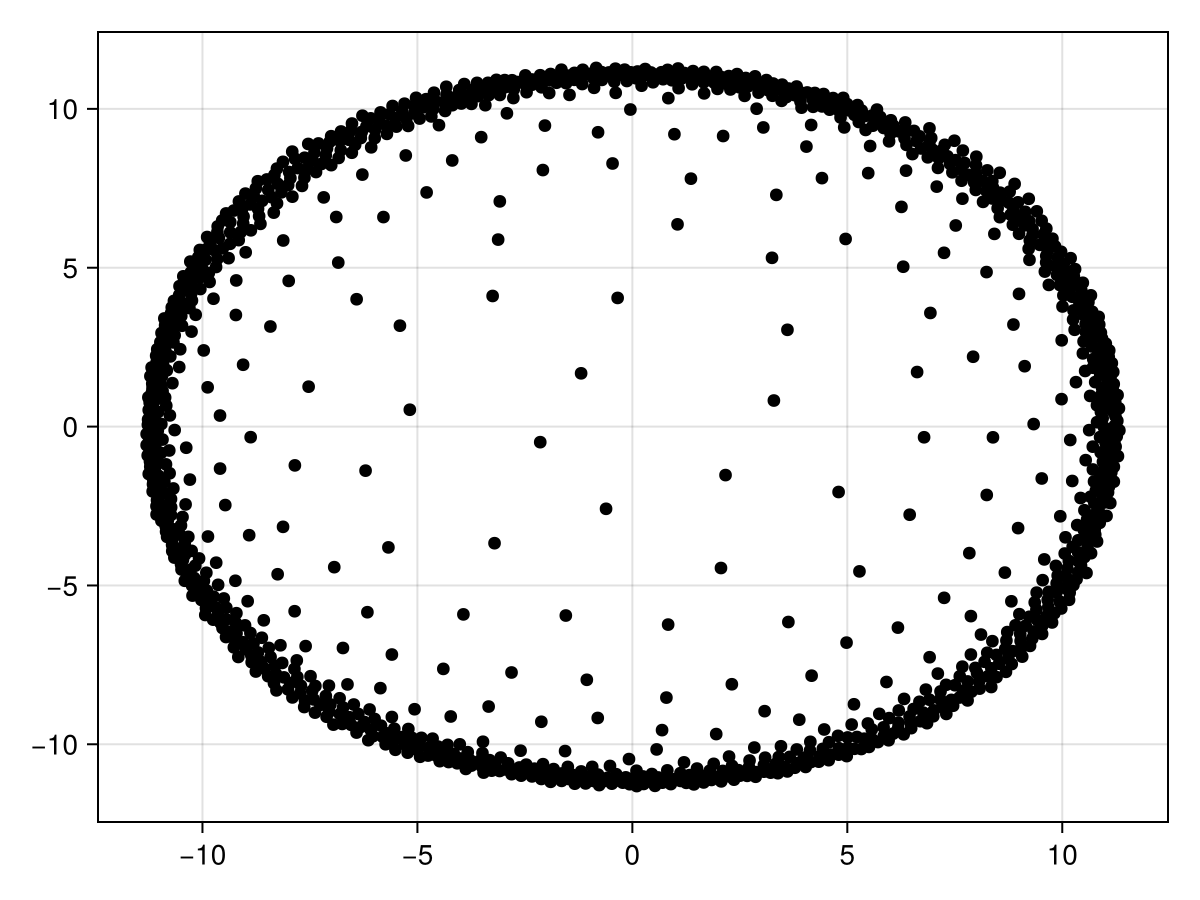

CairoMakie.Screen{IMAGE}


In [24]:
f, ax, p = graphplot(g) # Creates a plot object
display(f) # Displays the plot

In [25]:
fig = Figure(size = (1200, 800), fontsize = 22)
ga = GeoAxis(
    fig[1, 1],
    source = "+proj=longlat +datum=WGS84",
    dest = "+proj=lcc +lon_0=-100 +lat_1=33 +lat_2=45",
    title = "US Airline Locations",
)

GeoAxis()

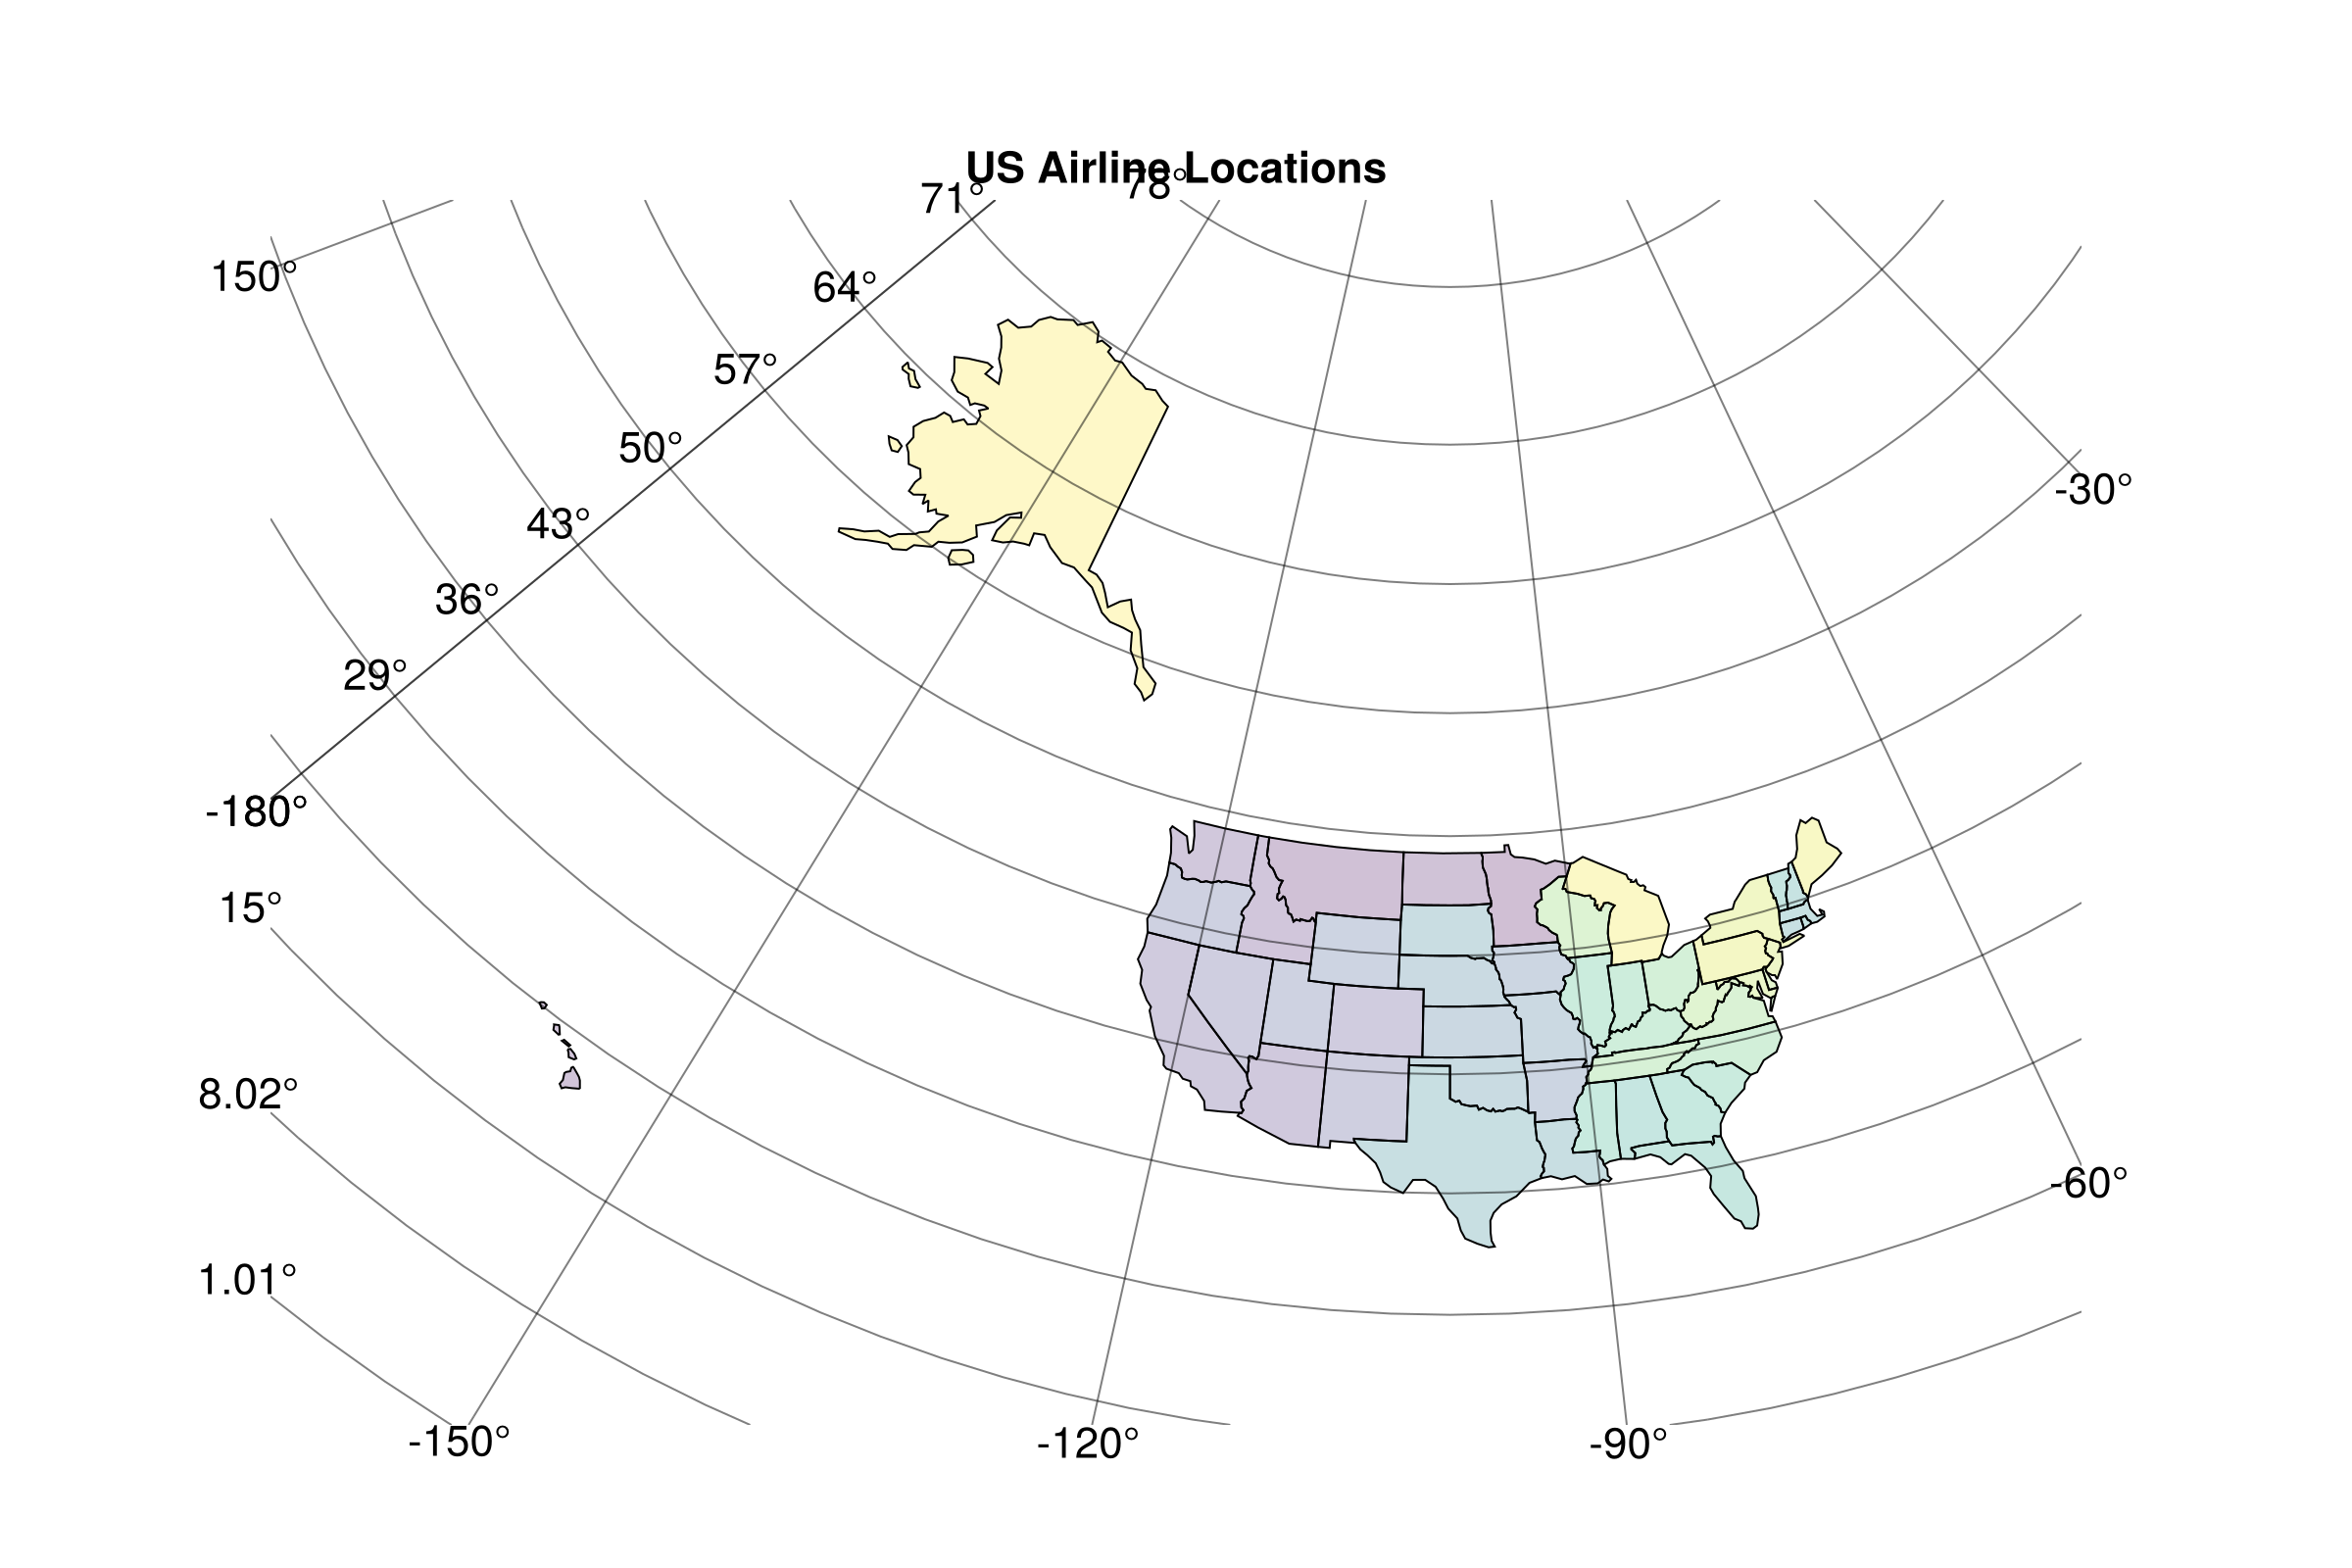

In [26]:
poly!(
    ga, admin_1_df.geometry;
    color = 1:n, colormap = (:viridis, 0.25),
    strokecolor = :black, strokewidth = 1
)
fig

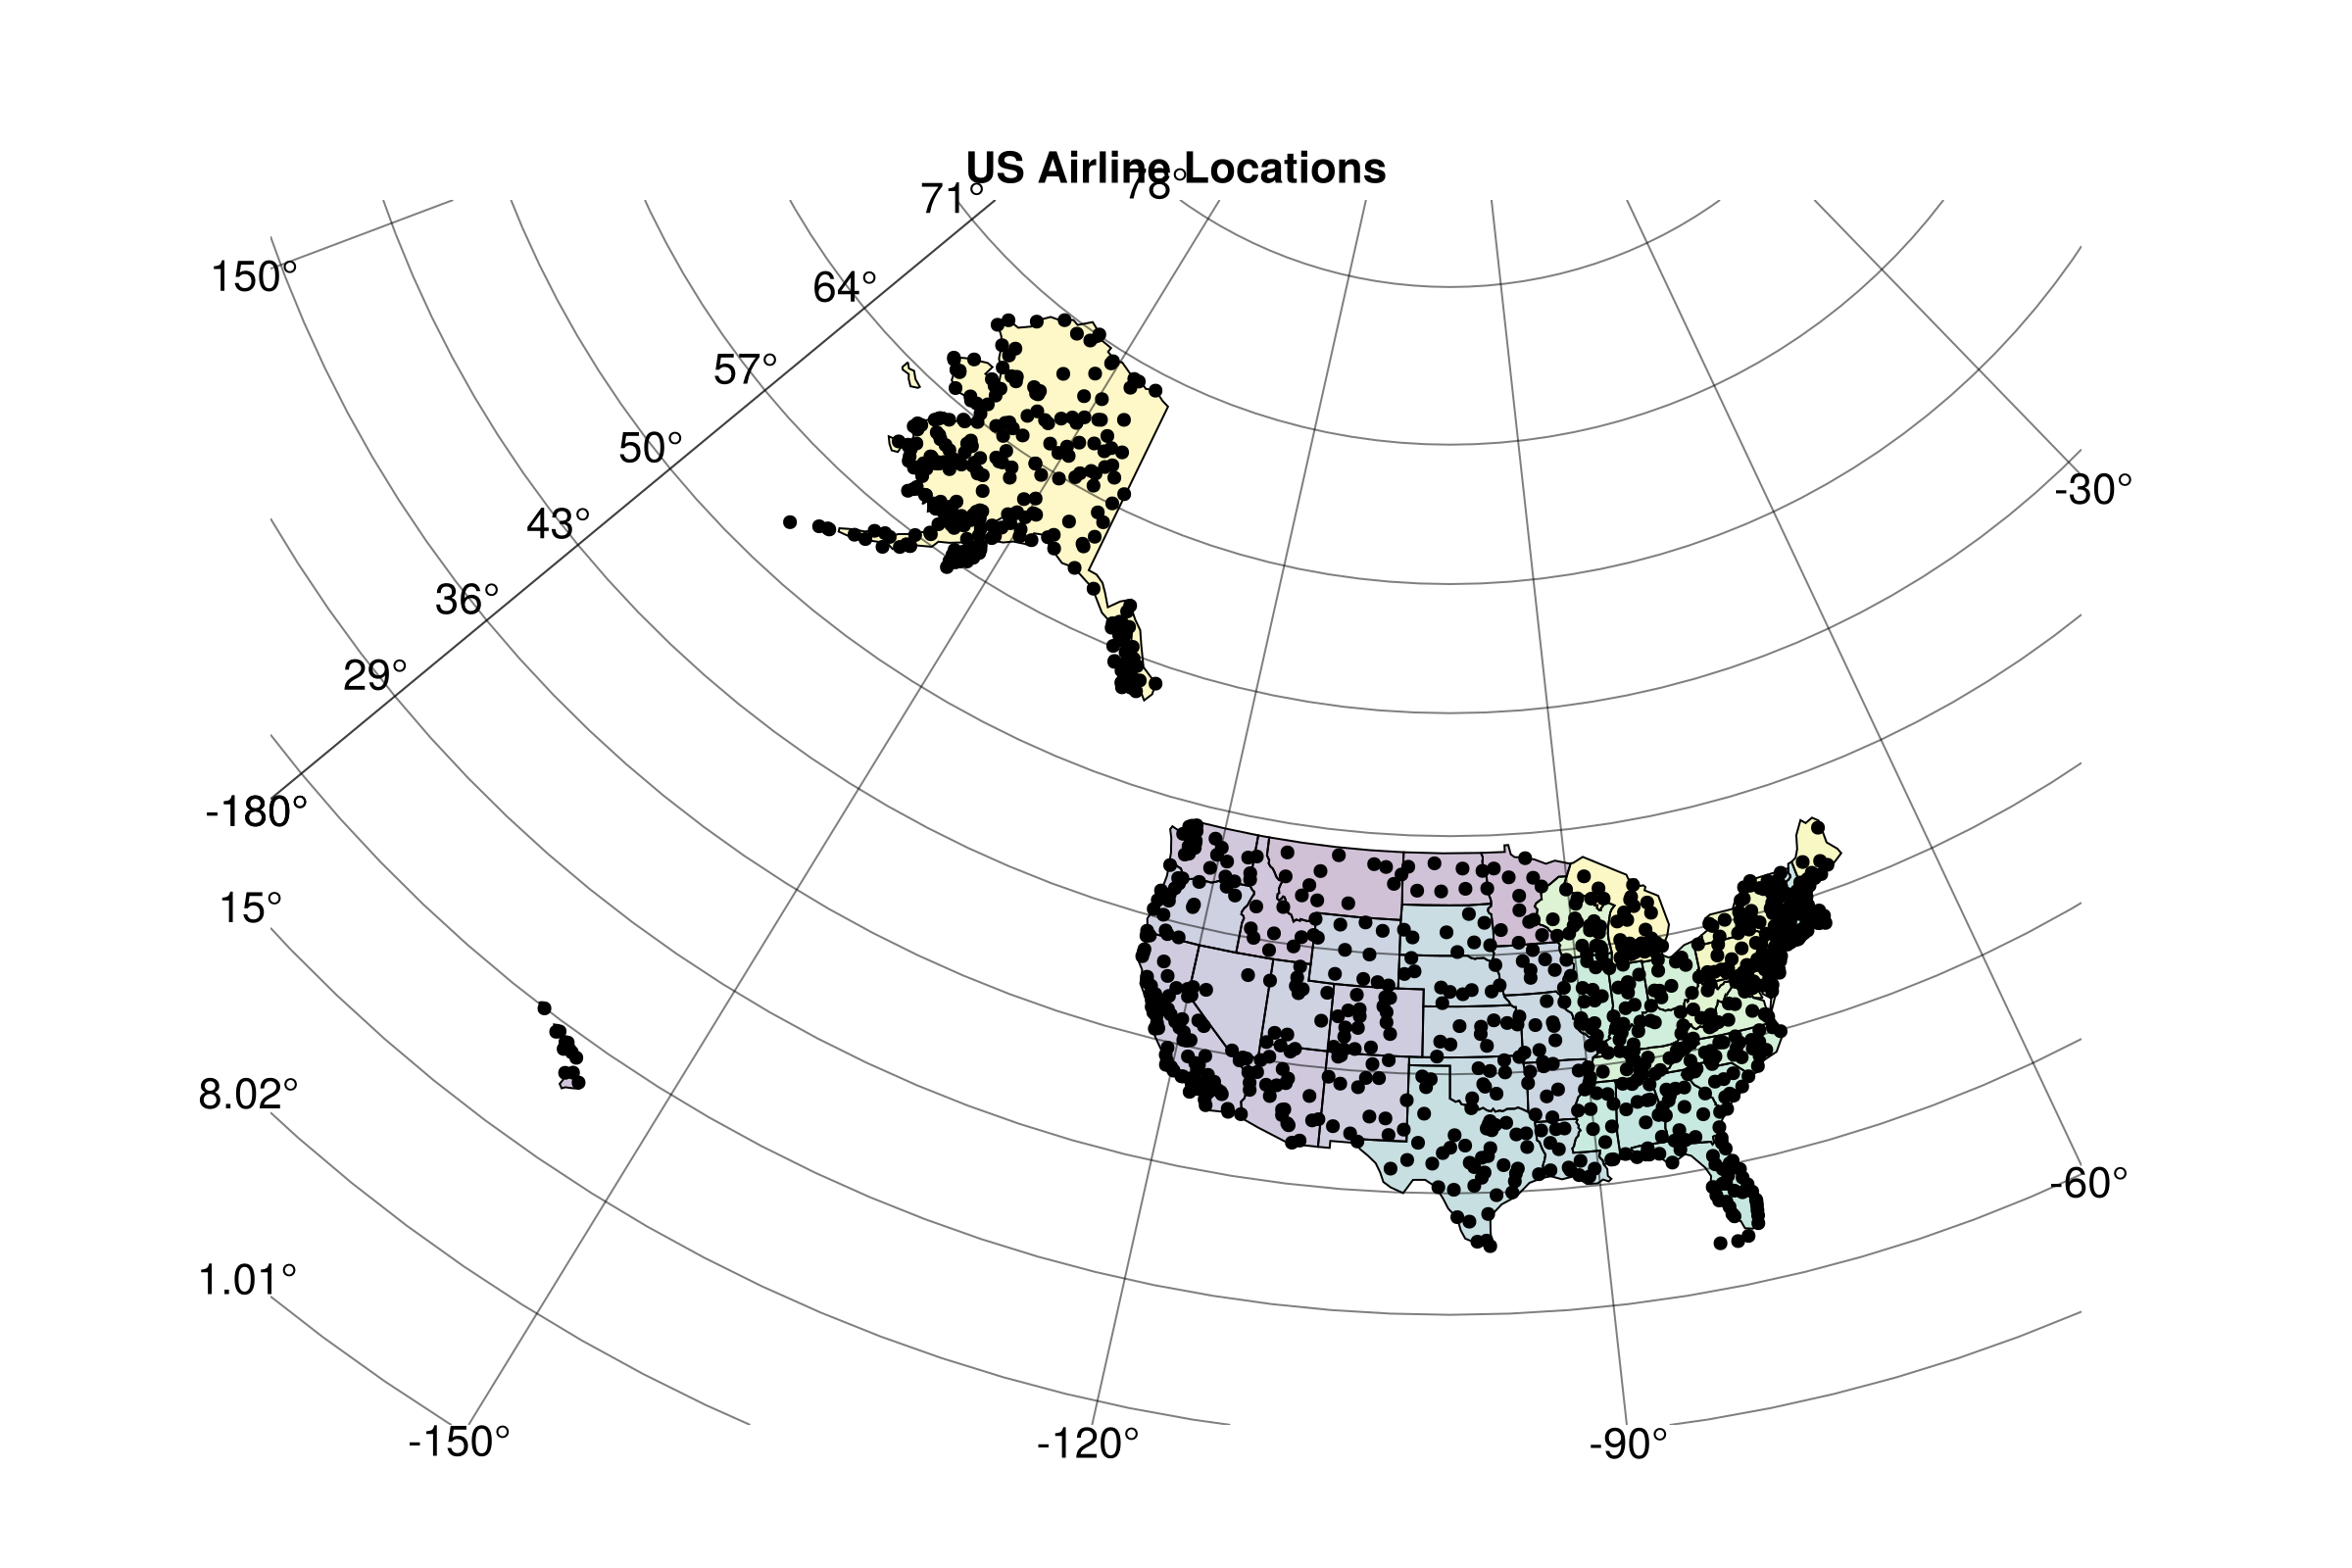

In [27]:
graphplot!(
    ga, g;
    layout = _ -> positions_vector, node_size = 10
)
fig

In [28]:
print(fig)

Scene(1 children, 0 plots)